In [2]:
#VAE code from PyTorch Tutorial

from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid

epochs = 10

parser = argparse.ArgumentParser(description='VAE MNIST Example')




device = torch.device("cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} 
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=128, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=128, shuffle=True, **kwargs)


class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 10)
        self.fc22 = nn.Linear(400, 10)
        self.fc3 = nn.Linear(10, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD


def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

if __name__ == "__main__":
    for epoch in range(1, epochs + 1):
        train(epoch)
        test(epoch)
        with torch.no_grad():
            sample = torch.randn(64, 10).to(device)
            sample = model.decode(sample).cpu()
            save_image(sample.view(64, 1, 28, 28),'cur_result/sample_' + str(epoch) + '.png')

Train Epoch: 1 [0/60000 (0%)]	Loss: 544.263611
Train Epoch: 1 [1280/60000 (2%)]	Loss: 287.877228
Train Epoch: 1 [2560/60000 (4%)]	Loss: 238.650284
Train Epoch: 1 [3840/60000 (6%)]	Loss: 225.708572
Train Epoch: 1 [5120/60000 (9%)]	Loss: 217.141953
Train Epoch: 1 [6400/60000 (11%)]	Loss: 210.569260
Train Epoch: 1 [7680/60000 (13%)]	Loss: 199.673798
Train Epoch: 1 [8960/60000 (15%)]	Loss: 201.364807
Train Epoch: 1 [10240/60000 (17%)]	Loss: 191.162750
Train Epoch: 1 [11520/60000 (19%)]	Loss: 187.648575
Train Epoch: 1 [12800/60000 (21%)]	Loss: 182.500702
Train Epoch: 1 [14080/60000 (23%)]	Loss: 185.123795
Train Epoch: 1 [15360/60000 (26%)]	Loss: 168.814819
Train Epoch: 1 [16640/60000 (28%)]	Loss: 174.357925
Train Epoch: 1 [17920/60000 (30%)]	Loss: 159.433289
Train Epoch: 1 [19200/60000 (32%)]	Loss: 167.036896
Train Epoch: 1 [20480/60000 (34%)]	Loss: 160.407867
Train Epoch: 1 [21760/60000 (36%)]	Loss: 146.450363
Train Epoch: 1 [23040/60000 (38%)]	Loss: 153.308456
Train Epoch: 1 [24320/60000 

Train Epoch: 4 [17920/60000 (30%)]	Loss: 121.895248
Train Epoch: 4 [19200/60000 (32%)]	Loss: 121.009064
Train Epoch: 4 [20480/60000 (34%)]	Loss: 114.120880
Train Epoch: 4 [21760/60000 (36%)]	Loss: 116.646469
Train Epoch: 4 [23040/60000 (38%)]	Loss: 121.956985
Train Epoch: 4 [24320/60000 (41%)]	Loss: 118.806877
Train Epoch: 4 [25600/60000 (43%)]	Loss: 119.027527
Train Epoch: 4 [26880/60000 (45%)]	Loss: 118.540039
Train Epoch: 4 [28160/60000 (47%)]	Loss: 118.097183
Train Epoch: 4 [29440/60000 (49%)]	Loss: 119.348007
Train Epoch: 4 [30720/60000 (51%)]	Loss: 118.317886
Train Epoch: 4 [32000/60000 (53%)]	Loss: 110.513969
Train Epoch: 4 [33280/60000 (55%)]	Loss: 116.524895
Train Epoch: 4 [34560/60000 (58%)]	Loss: 115.254120
Train Epoch: 4 [35840/60000 (60%)]	Loss: 118.760162
Train Epoch: 4 [37120/60000 (62%)]	Loss: 112.413101
Train Epoch: 4 [38400/60000 (64%)]	Loss: 120.980537
Train Epoch: 4 [39680/60000 (66%)]	Loss: 117.888779
Train Epoch: 4 [40960/60000 (68%)]	Loss: 118.180862
Train Epoch:

Train Epoch: 7 [35840/60000 (60%)]	Loss: 113.945946
Train Epoch: 7 [37120/60000 (62%)]	Loss: 113.811684
Train Epoch: 7 [38400/60000 (64%)]	Loss: 112.383789
Train Epoch: 7 [39680/60000 (66%)]	Loss: 117.530296
Train Epoch: 7 [40960/60000 (68%)]	Loss: 108.222321
Train Epoch: 7 [42240/60000 (70%)]	Loss: 117.236473
Train Epoch: 7 [43520/60000 (72%)]	Loss: 107.145370
Train Epoch: 7 [44800/60000 (75%)]	Loss: 110.905487
Train Epoch: 7 [46080/60000 (77%)]	Loss: 121.876434
Train Epoch: 7 [47360/60000 (79%)]	Loss: 110.715714
Train Epoch: 7 [48640/60000 (81%)]	Loss: 114.858505
Train Epoch: 7 [49920/60000 (83%)]	Loss: 114.711411
Train Epoch: 7 [51200/60000 (85%)]	Loss: 112.544395
Train Epoch: 7 [52480/60000 (87%)]	Loss: 111.892929
Train Epoch: 7 [53760/60000 (90%)]	Loss: 113.918823
Train Epoch: 7 [55040/60000 (92%)]	Loss: 110.049835
Train Epoch: 7 [56320/60000 (94%)]	Loss: 109.726074
Train Epoch: 7 [57600/60000 (96%)]	Loss: 115.401535
Train Epoch: 7 [58880/60000 (98%)]	Loss: 117.829033
====> Epoch:

Train Epoch: 10 [53760/60000 (90%)]	Loss: 108.960037
Train Epoch: 10 [55040/60000 (92%)]	Loss: 117.001579
Train Epoch: 10 [56320/60000 (94%)]	Loss: 113.702484
Train Epoch: 10 [57600/60000 (96%)]	Loss: 110.028297
Train Epoch: 10 [58880/60000 (98%)]	Loss: 110.290413
====> Epoch: 10 Average loss: 111.4429
====> Test set loss: 110.6257


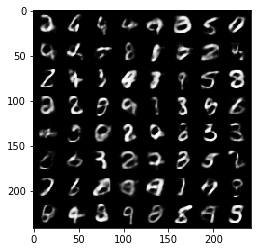

In [40]:
temp = torch.randn(64, 10).to(device)
temp = model.decode(temp).cpu()

with torch.no_grad():
    sample = torch.randn(64, 10).to(device)
    sample = model.decode(sample).cpu()
    show(make_grid(sample.view(64, 1, 28, 28)))

#imgplot = plt.imshow(temp2[:,1])
#print(type(temp2))

In [89]:
b = torch.tensor(XY).type(torch.FloatTensor).to(device)
sample = model.decode(b).cpu()
#shape(sample)
save_image(sample.view(64, 1, 28, 28),'cur_result/w.png')

In [53]:
from ipywidgets import interactive
from hilbert import HilbertCurve

def plotting(p=4, t=0.6):
    N = 10
    hilbert_curve = HilbertCurve(p, N)
    cur_dist = int(t * (2**(N*p)-1))
    dists = [cur_dist-10, cur_dist-5, cur_dist, cur_dist+5, cur_dist+10]
    
    coords = [hilbert_curve.coordinates_from_distance(dist) for dist in dists]

    norm_coords = np.array([[[(coord_x / (2**p))for coord_x in coord]]  for coord in coords])

    #norm_coords

    b = torch.tensor(norm_coords).type(torch.FloatTensor).to(device)
    sample = model.decode(b).cpu()
    #shape(sample)
    show(make_grid(sample.view(5, 1, 28, 28)))
    
    
interactive_plot = interactive(plotting, p = (1,10,1), t=(0,1,0.05))
interactive_plot

interactive(children=(IntSlider(value=4, description='p', max=10, min=1), FloatSlider(value=0.6, description='…